## Введение в CNN, классификация изображений

План:
1. Иллюстрация применения свёртки к изображению
2. `nn.Conv2D` и параметры
3. Max pooling, Average pooling, `nn.MaxPool2D`
4. Пример: классификация на CIFAR10

In [1]:
from collections import defaultdict
from typing import Callable

import matplotlib.pyplot as plt
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch import Tensor, nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 1. Свёртка

<img src="../attachments/conv-pad.svg" style="background:white" width="400"/>

In [2]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)
for k, v in conv.named_parameters():
    print(k, v)

weight Parameter containing:
tensor([[[[-0.3266,  0.3876],
          [ 0.4743,  0.4237]]]], requires_grad=True)
bias Parameter containing:
tensor([-0.4055], requires_grad=True)


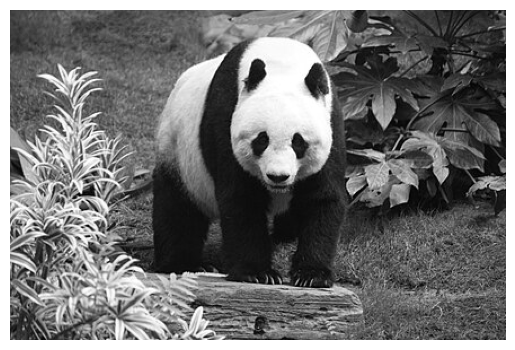

In [13]:
# IMAGE_URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/440px-Grosser_Panda.JPG"

# img = Image.open(requests.get(IMAGE_URL, stream=True).raw)
img = Image.open("../attachments/panda.jpg")
grayscale = img.convert("L")

plt.imshow(grayscale, cmap="gray")
plt.axis(False)
plt.show()

Зададим несколько фильтров. Что они делают?

In [4]:
filters = {
    "0": torch.tensor([[[
        [ 0,  0,  0],
        [ 0,  1,  0],
        [ 0,  0,  0],
    ]]], dtype=torch.float),
    "1": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  4, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "2": torch.tensor([[[
        [ 0, -1,  0],
        [-1,  5, -1],
        [ 0, -1,  0],
    ]]], dtype=torch.float),
    "3": torch.tensor([[[
        [ 1,  2,  1],
        [ 2,  4,  2],
        [ 1,  2,  1],
    ]]], dtype=torch.float) / 16,
}

Посмотрим на результаты:

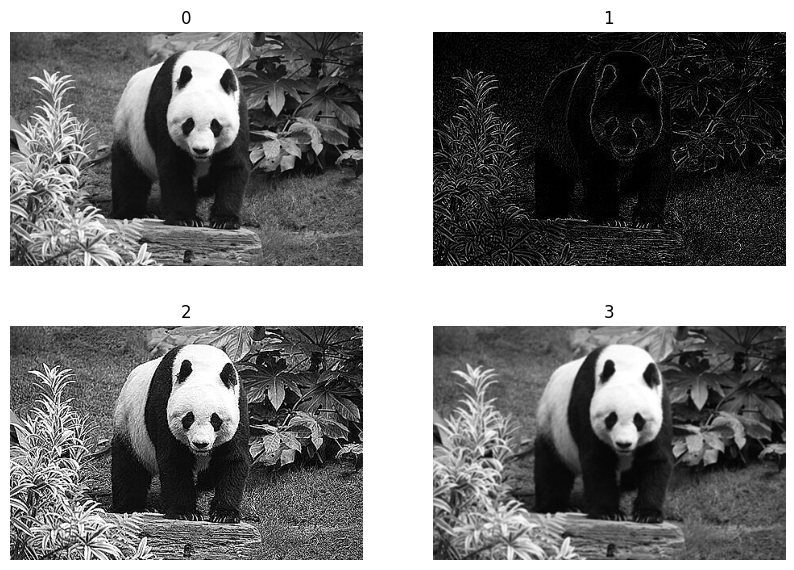

In [5]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 7))

# Создадим свёрточный слой и преобразуем изображение в тензор
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)
img_tensor = transforms.ToTensor()(grayscale)

for k, (filter_name, filter_kernel) in enumerate(filters.items()):
    # подставим значения для фильтра в свёрточный слой
    conv.weight.data = filter_kernel

    # преобразуем входное изображение и обрежем до отрезка [0, 1] для корректного отображения
    transformed = conv(img_tensor).detach().numpy()[0].clip(0, 1)
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transformed, cmap="gray")
    ax.set_title(filter_name)
    ax.set_axis_off()

plt.show()

### 2. `nn.Conv2D`

Свёртка входного тензора размера $(N, C_{\text{in}}, H, W)$ в тензор размера $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$ описывается так:

<!-- In the simplest case, the output value of the layer with input size
$(N, C_{\text{in}}, H, W)$ and output $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$    can be precisely described as: -->
    
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)$$

$\star$ - 2D оператор кросс-корреляции, $N$ - размер батча, $C$ - количество каналов, $H$ и $W$ - высота и ширина в пикселах соответственно

<!-- $\star$ is the valid 2D `cross-correlation`_ operator,$N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels. -->

Каждый `nn.Conv2D` слой содержит две группы параметров:
- `weight`: тензор размера $(C_{out}, C_{in}, H_k, W_k)$
  - $C_{in}$: количество входных каналов
  - $C_{out}$: количество выходных каналов
  - $(H_k, W_k)$: размер 2D кернела (например, $3 \times 3$)
- `bias`: тензор размера $(C_{out},)$

Кроме того, регулировать количество параметров можно с помощью аргументов конструктора
- `bias (bool)`: включение / отключения параметра сдвига
- `groups`: число групп, на которые следует разбить входные и выходные каналы; каждый фильтр работает только с одной группой каналов

![GroupConv](https://www.researchgate.net/publication/351823568/figure/fig2/AS:1027082138181632@1621886872538/Standard-convolution-left-and-group-convolution-right.ppm)

**Упражнение**: сколько параметров будет в свёрточном слое с размером кернела $3 \times 3$ для преобразования тензора с 3 каналами в тензор с 6 каналами без группировки? С разделением на 3 группы?

Другие параметры, влияющие на результат свёртки
- `stride`: каков размер смещения между соседними срезами, к которым применяется свёртка
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

Демо: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

<table style="width:100%; table-layout:fixed;">
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/arbitrary_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/same_padding_no_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/full_padding_no_strides.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Arbitrary padding, no strides</td>
    <td>Half padding, no strides</td>
    <td>Full padding, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/no_padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/padding_strides_odd.gif?raw=true"></td>
    <td><img width="150px" src="https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/dilation.gif?raw=true"></td>
  </tr>
  <tr>
    <td>No padding, strides</td>
    <td>Padding, strides</td>
    <td>Padding, strides (odd)</td>
    <td>No padding, no stride, dilation</td>
  </tr>
</table>



### 3. Max pooling

![maxpool](../attachments/maxpool.png)

Параметры инициализации `nn.MaxPool2d` (а так же `nn.AvgPool2d`) похожи на свёрточный слой:
- `kernel_size`: размер 2D кернела (обычно $2 \times 2$)
- `stride`: каков размер смещения между соседними срезами, к которым применяется pooling (обычно 2, т.е. без наложения)
- `padding`: как дополнить входной тензор пикселами вокруг
- `dilation`: позволяет взять не связный срез, а растянутый, с просветом между пикселами

Характерный строительный блок для свёрточной сети:
- `Conv -> ReLU -> MaxPool`
- В каждом следующем блоке размер активаций уменьшается (обычно в 4 раза), размер каналов увеличивается

Для того, чтобы перед линейным слоем размер активаций был одинаковым для любого размера входного изображения, есть `nn.AdaptiveMaxPool2d`

### 4. Пример: классификация CIFAR10

In [6]:
torch.manual_seed(42)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на примеры изображений:

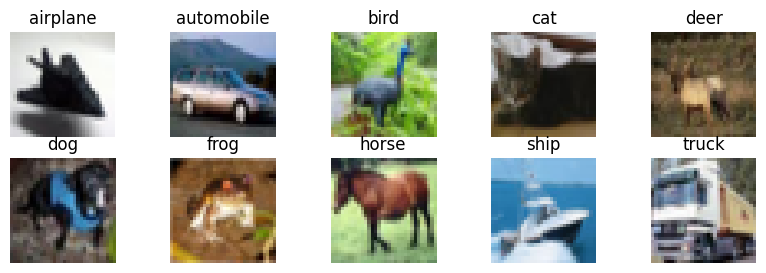

In [7]:
nrows = 2
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3))
for k, label in enumerate(train_dataset.classes):
    example = next(img for img, target in train_dataset if target == k)
    # unnormalize images
    example = 0.5 * example + 0.5
    row = k // ncols
    column = k % ncols
    ax = axes[row][column]
    ax.imshow(transforms.ToPILImage()(example), cmap="gray")
    ax.set_title(label)
    ax.set_axis_off()

plt.show()

In [8]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Определим простую архитектуру: 2 блока из свёртки и maxpooling, три линейных слоя, ReLU в качестве нелинейности

In [9]:
class CNNet(nn.Module):
    def __init__(self, num_classes: int = 10, input_channels: int = 3):
        super().__init__()
        self._num_classes = num_classes
        # conv block
        self.conv1 = nn.Conv2d(input_channels, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)

        # linear block
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    @property
    def num_classes(self) -> int:
        return self._num_classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Наши функции для запуска обучения:

In [10]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str = "cpu",
) -> tuple[Tensor, Tensor]:
    model.to(device=device)
    # прогоняем батч через модель
    x, y = batch
    logits = model(x.to(device=device))
    # оцениваем значение ошибки
    loss = F.cross_entropy(logits, y.to(device=device))
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, logits


def train_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    max_batches: int = 100,
    device: str = "cpu",
) -> dict[str, float]:
    model.train()
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        loss, logits = training_step(batch, model, optimizer, device)

        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


@torch.no_grad()
def test_epoch(
    dataloader: DataLoader,
    model: nn.Module,
    max_batches: int = 100,
    device: str = "cpu",
) -> Tensor:
    model.eval()
    model.to(device=device)
    loss_total = 0
    n_correct = 0
    n_total = 0
    for i, batch in enumerate(dataloader):
        x, y = batch
        logits = model(x.to(device=device))
        # оцениваем значение ошибки
        loss = F.cross_entropy(logits, y.to(device=device))
        # save stats
        n_total += y.size(0)
        n_correct += (y.to(device=device) == logits.argmax(dim=1)).sum()
        loss_total += y.size(0) * loss.item()
        if i == max_batches:
            break

    return {
        "loss": loss_total / n_total,
        "accuracy": n_correct / n_total,
    }


def run_experiment(
    model_gen: Callable[[], nn.Module],
    optim_gen: Callable[[nn.Module], torch.optim.Optimizer],
    seed: int,
    n_epochs: int = 10,
    max_batches: int | None = None,
    verbose: bool = False,
    device: str = "cpu",
) -> dict[str, list[float]]:
    """Функция для запуска экспериментов.

    Args:
        model_gen (Callable[[], nn.Module]): Функция для создания модели
        optim_gen (Callable[[nn.Module], torch.optim.Optimizer]): Функция для создания оптимизатора для модели
        seed (int): random seed
        n_epochs (int, optional): Число эпох обучения. Defaults to 10.
        max_batches (int | None, optional): Если указано, только `max_batches` минибатчей
            будет использоваться при обучении и тестировании. Defaults to None.
        verbose (bool, optional): Выводить ли информацию для отладки. Defaults to False.

    Returns:
        tuple[list[float], list[float]]: Значения ошибки на обучающей и тестовой выборках по всем эпохам
    """
    torch.manual_seed(seed)
    # создадим модель и выведем значение ошибки после инициализации
    model = model_gen()
    optim = optim_gen(model)
    metrics: dict[str, list[float]] = defaultdict(list)
    for i in range(n_epochs):
        train_dict = train_epoch(
            train_loader, model, optim, max_batches=max_batches, device=device
        )
        test_dict = test_epoch(
            test_loader, model, max_batches=max_batches, device=device
        )
        train_loss, train_accuracy = train_dict["loss"], train_dict["accuracy"]
        test_loss, test_accuracy = test_dict["loss"], test_dict["accuracy"]
        if verbose:
            print(
                f"Epoch {i} train: loss = {train_loss:.4f}, accuracy = {train_accuracy:.4f}"
            )
            print(
                f"Epoch {i} test: loss = {test_loss:.4f}, accuracy = {test_accuracy:.4f}"
            )

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
        metrics["test_losses"].append(test_loss)
        metrics["test_accuracies"].append(test_accuracy)

    return metrics

Запустим эксперимент

In [11]:
metrics_dict = run_experiment(
    model_gen=lambda: CNNet(),
    optim_gen=lambda x: torch.optim.Adam(x.parameters(), lr=0.001, weight_decay=0.00),
    seed=42,
    n_epochs=10,
    max_batches=None,
    verbose=True,
    device="cpu",
)

Epoch 0 train: loss = 1.4968, accuracy = 0.4598
Epoch 0 test: loss = 1.2495, accuracy = 0.5469
Epoch 1 train: loss = 1.1594, accuracy = 0.5886
Epoch 1 test: loss = 1.0807, accuracy = 0.6136
Epoch 2 train: loss = 1.0121, accuracy = 0.6428
Epoch 2 test: loss = 1.0094, accuracy = 0.6437
Epoch 3 train: loss = 0.9094, accuracy = 0.6811
Epoch 3 test: loss = 0.9735, accuracy = 0.6614
Epoch 4 train: loss = 0.8296, accuracy = 0.7097
Epoch 4 test: loss = 0.9663, accuracy = 0.6662
Epoch 5 train: loss = 0.7686, accuracy = 0.7318
Epoch 5 test: loss = 0.9112, accuracy = 0.6860
Epoch 6 train: loss = 0.7149, accuracy = 0.7508
Epoch 6 test: loss = 0.9471, accuracy = 0.6836
Epoch 7 train: loss = 0.6701, accuracy = 0.7649
Epoch 7 test: loss = 0.9297, accuracy = 0.6810
Epoch 8 train: loss = 0.6243, accuracy = 0.7797
Epoch 8 test: loss = 1.0047, accuracy = 0.6761
Epoch 9 train: loss = 0.5851, accuracy = 0.7953
Epoch 9 test: loss = 0.9655, accuracy = 0.6873
